# Description of Problem and Data
The task at hand is to classify histopathologic scans of lymph nodes as either cancerous or non-cancerous.

The data is patches taken from larger scans in the form of images.  As mentioned in the description, the data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset.  The data is 32x32px images.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
from glob import glob

# Exploratory Data Analysis

## Observing the Data
First we will inspect the labels to see what we are working with.

In [3]:
# Load labels
labels_csv_path = 'train_labels.csv'
labels = pd.read_csv(labels_csv_path)

# Display the first few rows of the dataframe
print(labels.head())

# Check for missing values
print(labels.isnull().sum())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
id       0
label    0
dtype: int64


From this, we can see that we are given truth data in the form of the ID of the scan, and if it is cancerous or not.
According to Kaggle, if at least one pixel is cancerous, we are given a positive label of 1.

## Observing an image
Now let's take a look at an example image in the dataset.

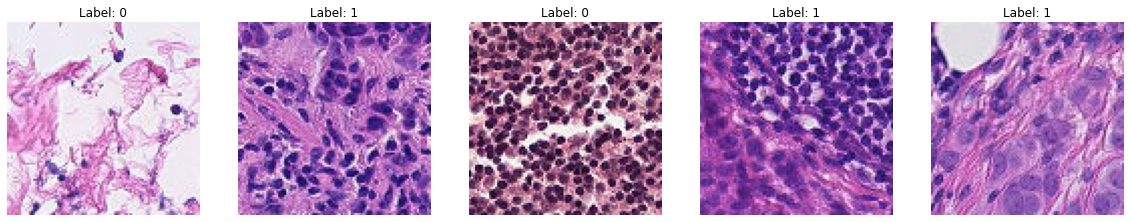

In [9]:
def display_sample_images(paths, labels, n=5):
    plt.figure(figsize=(20, 10))
    for i, (path, label) in enumerate(zip(paths[:n], labels[:n])):
        img = Image.open(path)
        plt.subplot(1, n, i+1)
        plt.title(f'Label: {label}')
        plt.imshow(img)
        plt.axis('off')
    plt.show()

images_dir = 'data'
image_paths = glob(os.path.join(images_dir, '*.tif'))
sample_paths = image_paths[:5]
sample_labels = [labels.loc[labels['id'] == os.path.splitext(os.path.basename(x))[0], 'label'].values[0] for x in sample_paths]

display_sample_images(sample_paths, sample_labels)

This is pretty interesting to see, and provides some potential insights into analysis.  Some basic observations I am making are that the cancerous ones tend to be a brighter purple, where as the non-cancerous are more of a dull purple or have white backgrounds.  I am curious if this holds true throughout. 

## Learning about the dataset
Let's find out how many of the samples are cancerous.  In the chart below, we can see that more of the samples are not cancerous than cancerous.

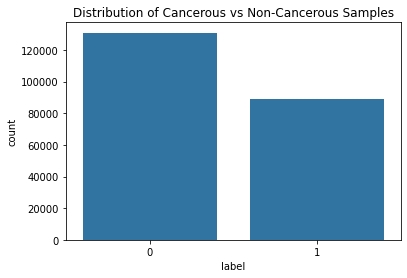

In [4]:
sns.countplot(x='label', data=labels)
plt.title('Distribution of Cancerous vs Non-Cancerous Samples')
plt.show()

### Pixel Intensity Distribution
This is an interesting EDA component.  We can see in the chart below that there is a spike of pixel intensity around 240 (255 is highest).  This may be relevant, or maybe it is a "natural" background color that could be worth filtering out.

Notably, this distribution means there are likely no contrast or brightness adjustments required, which is easier for preprocessing.

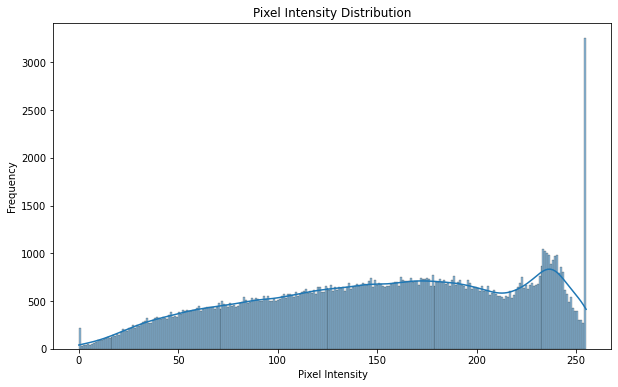

In [11]:
def plot_pixel_intensity_distribution(image_paths):
    intensities = []
    for path in image_paths:
        img = Image.open(path)
        img = np.array(img)
        intensities.extend(img.ravel())
    
    plt.figure(figsize=(10, 6))
    sns.histplot(intensities, bins=256, kde=True)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Analyze a sample of images
plot_pixel_intensity_distribution(sample_paths)

### Dataset Integrity
Let's examine if the images in the dataset are all the same size, which will be important for the model.
It appears they are all the same size.  This was likely the case, but it was still important to certify.  "In the field", this is not always the case.

In [12]:
def check_image_sizes(image_paths, sample_size=100):
    sizes = {}
    for path in image_paths[:sample_size]:  # Check the first 100 images
        img = Image.open(path)
        size = img.size
        if size in sizes:
            sizes[size] += 1
        else:
            sizes[size] = 1
    return sizes

sizes = check_image_sizes(image_paths)
print(sizes)

{(96, 96): 39}


### What about Data Augmentation?
Remember how we saw that there are more non-cancerous than cancerous?  Typically we would augment the data to combat this.  In this case, it falls out of the scope of doing this.

# Model Architecture
Now it is time to define a model.  There are many types of CNN architectures, and its sometimes best to use a proven one instead of a made up one.
A few to consider are ResNet50, VGG19, and Xception (InceptionV3).  Since Xception is a very deep model that is able to filter data and consider "the big picture", it is a good candidate. 

However, for the sake of the school project, I believe I am supposed to define a model myself.  

I am going to do a CNN with dropout layers, regularization and batch normalization for faster convergence.  
It will have 3 blocks, and then a final connected later for binary classification.  The size is mostly for training feasibility reasons.

In [18]:
# Let's pull in the libraries for defining the model.  I prefer to do this in TensorFlow/Keras, which is aligned with the course curriculum.
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
# Model definition
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), padding='same', input_shape=(96, 96, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Fully Connected Layer
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

Now that the model is defined, lets compile it.  We will use the adam optimizer and binary crossentropy

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 96, 96, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1

## Model 2
I want to experiment with how much the dropout layers improve or harm the model.  Therefore, I am going to create a similar model with no dropout layers.

In [54]:
# Model definition
model_2 = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), padding='same', input_shape=(96, 96, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Fully Connected Layer
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [55]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_6 (Bat  (None, 96, 96, 32)        128       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 48, 48, 64)       

# Results and Analysis
This section is focused heavily on the training.

## Training Setup

In [48]:
# Changing the labels df from above because we have to make slight alterations to it.
training_df = pd.read_csv('train_labels.csv')
training_df['id'] = training_df['id'].apply(lambda x: f"{x}.tif")
training_df['label'] = training_df['label'].astype(str)

# A sanity check that IDs match files.  Commented out because it only needs to run once, and it is slow.
# missing_files = [file for file in training_df['id'] if not os.path.isfile(os.path.join('train/', file))]
# print(f"Missing files: {len(missing_files)}")

# Rescale pixel values from [0, 255] to [0, 1] for both generators.
# Normalizing like this can help with the training process.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_df,
    directory='train/',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

Found 220025 validated image filenames belonging to 2 classes.


## Validation Setup

In [ ]:
# And setup the validatort tests
validation_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation data

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=training_df,
    directory='test/',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

## Training Process
And now, train.  This is pretty slow, even for a single epoch.

In [52]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,  # Number of epochs
)
    # validation_data=validation_generator,
    # validation_steps=validation_generator.samples // validation_generator.batch_size)


6875/6875 [==============================] - 2205s 321ms/step - loss: 0.2892 - accuracy: 0.8823


### Saving the model for later

In [53]:
model.save('model_checkpoints/model_a2')

INFO:tensorflow:Assets written to: model_checkpoints/model_a2\assets


INFO:tensorflow:Assets written to: model_checkpoints/model_a2\assets


### Model 1 Notes
It appears after just 2 epochs of the entire training set, model 1 has converged at an accuracy of about 0.8823.  This seems pretty good for an intermediate level of complexity and relatively short training time.

### Model 2 Training
Model 2 will be trained for 2 epochs as well.  Remember that this model is similar to model 1, but has no dropout layers.  The goal of this model is to determine if the dropout layers help or harm (or neither).

In [56]:
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,
)

Epoch 1/2
6875/6875 [==============================] - 2039s 296ms/step - loss: 0.3521 - accuracy: 0.8504
Epoch 2/2
6875/6875 [==============================] - 1866s 271ms/step - loss: 0.2549 - accuracy: 0.8996


In [57]:
model_2.save('model_checkpoints/model_b')

INFO:tensorflow:Assets written to: model_checkpoints/model_b\assets


INFO:tensorflow:Assets written to: model_checkpoints/model_b\assets


## Generating Test Prediction CSVs
Now it is time to see how the models perform on the test set.  In order to do so, a CSV of predictions must be generated and uploaded to Kaggle.

In [60]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

test_dir = 'test'  # Adjust this to the path of your test images
test_image_paths = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]

# A helper function to scale the image and prepare it for prediction
def preprocess_image(image_path, target_size=(96, 96)):
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0  # Scale pixel values to [0, 1]
    return img

# Preprocess all test images
test_images = np.vstack([preprocess_image(path) for path in test_image_paths])

# First model
predictions = model.predict(test_images, batch_size=32)

test_ids = [os.path.splitext(os.path.basename(path))[0] for path in test_image_paths]

submission_df = pd.DataFrame({
    'id': test_ids,
    'label': predictions.flatten()
})

submission_df.to_csv('submission_model_1.csv', index=False)

# Second model
predictions_2 = model_2.predict(test_images, batch_size=32)

submission_2_df = pd.DataFrame({
    'id': test_ids,
    'label': predictions_2.flatten()
})

submission_2_df.to_csv('submission_model_2.csv', index=False)

1796/1796 [==============================] - 86s 47ms/step


# Conclusion
This project was very insightful into data preprocessing, model design, and training.

A few takeaways:
- The dropout layers had little to no impact on accuracy.  This is not always the case.
- The models converged quickly (2 epochs)
- A more advanced model, or better processing/training is needed to improve performance.  More training alone won't help.

Future Improvements:
- Transfer learning
- TensorFlow GPU compatibility for faster training
- More Data Preprocessing, such as filtering

## Kaggle Results
My first model with dropout layers was not very good on the scoreboard, about 0.81.  My second, however, was 0.88.  The only difference in the second model was I had no dropout layers.  I was suprised by this, and impressed at how much of a different that made.  This is still on the lower half of the scoreboard, and I think I could do a lot better with more effort and training.

Overall, this was an extremely valuable assignment that was good practice in EDA, creating a model, training a model, and testing it.
I also was not aware of Kaggle, so finding this is great.  I think I might do more Kaggle challenges in the future.